In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

1. Import data

In [2]:
file_path = 'mieszkania_z_koordynatami_FULL.csv'

df = pd.read_csv(file_path)

print(df.head(3))

       advertiser_type   area   available_from  build_year building_type  \
0  biuro nieruchomości  58.00  brak informacji      2019.0   szeregowiec   
1  biuro nieruchomości  55.00  brak informacji      1980.0          blok   
2  biuro nieruchomości  57.07       2025-01-21      2024.0          blok   

     city                                        description  \
0  Kraków  Kraków / Opatkowice/ Swoszowice / ul. Macieja ...   
1  Kraków  Oferta sprzedaży mieszkania 3-pokojowego położ...   
2  Kraków  Na sprzedaż piękne mieszkanie w nowej inwestyc...   

           district                                          equipment  \
0        Swoszowice  meble,zmywarka,kuchenka,telewizor,pralka,lodów...   
1  Prądnik Czerwony   meble,zmywarka,kuchenka,pralka,lodówka,piekarnik   
2           Dębniki                                                NaN   

           extras  ...       region   rent  rooms  \
0     ogród,taras  ...  małopolskie  260.0      3   
1  balkon,piwnica  ...  małopolskie

In [3]:
df.columns

Index(['advertiser_type', 'area', 'available_from', 'build_year',
       'building_type', 'city', 'description', 'district', 'equipment',
       'extras', 'finish', 'floor', 'floor_number', 'heating', 'latitude',
       'lift', 'location', 'longitude', 'market', 'material', 'media',
       'neighbourhood', 'ownership', 'price', 'price_per_m2', 'region', 'rent',
       'rooms', 'security', 'street', 'title', 'total_floors', 'url',
       'windows', 'coord_type'],
      dtype='object')

2. Data Preprocessing

In [4]:
# Poprawa kolumny 'city' na 'Kraków' tam, gdzie 'location' zawiera 'Kraków'
df.loc[(df['city'] != 'Kraków') & (df['location'].str.contains('Kraków', na=False)), 'city'] = 'Kraków'

In [5]:
# Lista znanych dzielnic Krakowa
districts = ['Stare Miasto', 'Grzegórzki', 'Prądnik Czerwony', 'Prądnik Biały', 'Krowodrza', 'Zwierzyniec',
             'Bronowice', 'Dębniki', 'Łagiewniki-Borek Fałęcki', 'Swoszowice', 'Podgórze Duchackie',
             'Bieżanów-Prokocim', 'Podgórze', 'Czyżyny', 'Mistrzejowice', 'Bieńczyce', 'Wzgórza Krzesławickie', 'Nowa Huta']

# Funkcja do wyciągania dzielnicy z location
def extract_district(location):
    if pd.isnull(location):
        return None
    for district in districts:
        if district in location:
            return district
    return None

# Kopia oryginalnej kolumny district (dla porównania)
df['district_original'] = df['district']

# Nowa kolumna district_clean — tylko poprawne dzielnice
df['district_clean'] = df.apply(
    lambda row: row['district'] if row['district'] in districts else extract_district(row['location']),
    axis=1
)

In [6]:
# === Mapa district_id ===
district_mapping = {
    'Stare Miasto': 1,
    'Grzegórzki': 2,
    'Prądnik Czerwony': 3,
    'Prądnik Biały': 4,
    'Krowodrza': 5,
    'Bronowice': 6,
    'Zwierzyniec': 7,
    'Dębniki': 8,
    'Łagiewniki-Borek Fałęcki': 9,
    'Swoszowice': 10,
    'Podgórze Duchackie': 11,
    'Bieżanów-Prokocim': 12,
    'Podgórze': 13,
    'Czyżyny': 14,
    'Mistrzejowice': 15,
    'Bieńczyce': 16,
    'Wzgórza Krzesławickie': 17,
    'Nowa Huta': 18
}

# === Tworzenie kolumny district_id ===
df['district_id'] = df['district_clean'].map(district_mapping)

In [7]:
# Rekordy, które nadal NIE mają poprawnej dzielnicy (do sprawdzenia)
df_missing_district = df[df['district_clean'].isnull() | (~df['district_clean'].isin(districts))]

# Podsumowanie - ile jest takich przypadków
print("Liczba rekordów z brakującą lub niepoprawną dzielnicą:", len(df_missing_district))

df_missing_district[['location', 'district', 'district_original', 'city']]

Liczba rekordów z brakującą lub niepoprawną dzielnicą: 27


,location,district,district_original,city
27,"Skawina, Skawina, krakowski, małopolskie",Skawina,Skawina,krakowski
57,"ul. Wiarusa, Zielonki, Zielonki, krakowski, ma...",Zielonki,Zielonki,krakowski
85,"ul. Topolowa, Wieliczka, Wieliczka, wielicki, ...",Wieliczka,Wieliczka,wielicki
393,"ul. Na Popielówkę, Zielonki, Zielonki, krakows...",Zielonki,Zielonki,krakowski
538,"ul. Wiarusa, Zielonki, Zielonki, krakowski, ma...",Zielonki,Zielonki,krakowski
548,"ul. Na Popielówkę, Zielonki, Zielonki, krakows...",Zielonki,Zielonki,krakowski
864,"ul. Krakowska, Wieliczka, Wieliczka, wielicki,...",Wieliczka,Wieliczka,wielicki
890,"Wieliczka, Wieliczka, Wieliczka, wielicki, mał...",Wieliczka,Wieliczka,Wieliczka
1328,"ul. Wygoda, Czarnochowice, Wieliczka, wielicki...",Wieliczka,Wieliczka,wielicki
1336,"Czarnochowice, Czarnochowice, Wieliczka, wieli...",Czarnochowice,Czarnochowice,Wieliczka


In [8]:
# Liczba ogłoszeń PRZED filtrowaniem
print(f"Ogłoszeń PRZED filtrowaniem city: {len(df)}")

# Filtrowanie - tylko city == 'Kraków'
df = df[df['city'] == 'Kraków'].copy()

# Liczba ogłoszeń PO filtrowaniu
print(f"Ogłoszeń PO filtrowaniu city == 'Kraków': {len(df)}")

Ogłoszeń PRZED filtrowaniem city: 4868
Ogłoszeń PO filtrowaniu city == 'Kraków': 4841


In [9]:
# Rekordy, które nadal NIE mają poprawnej dzielnicy (do sprawdzenia)
df_missing_district = df[df['district_clean'].isnull() | (~df['district_clean'].isin(districts))]

# Podsumowanie — ile jest takich przypadków
print("Liczba rekordów z brakującą lub niepoprawną dzielnicą:", len(df_missing_district))

Liczba rekordów z brakującą lub niepoprawną dzielnicą: 0


In [10]:
# === Kopie danych PRZED czyszczeniem ===
price_per_m2_before = df['price_per_m2']
area_before = df['area']

In [11]:
print('min', min(df['price_per_m2']), 'max', max(df['price_per_m2']), 'mediana', df['price_per_m2'].median(), 'srednia0', df['price_per_m2'].mean())
print('min', min(df['area']), 'max', max(df['area']),'mediana', df['area'].median(), 'srednia0', df['area'].mean())

min 3650.0 max 79800.0 mediana 15818.0 srednia0 16855.784548646974
min 11.15 max 332.0 mediana 50.0 srednia0 55.620687874406116


In [12]:
# === CZYSZCZENIE price_per_m2 ===
Q1_p = df['price_per_m2'].quantile(0.25)
Q3_p = df['price_per_m2'].quantile(0.75)
IQR_p = Q3_p - Q1_p
lower_bound_p = Q1_p - 1.5 * IQR_p
upper_bound_p = Q3_p + 1.5 * IQR_p

outliers_count = df[(df['price_per_m2'] < lower_bound_p) | (df['price_per_m2'] > upper_bound_p)].shape[0]

print(f"lower {lower_bound_p} and uper {upper_bound_p}")
print(f"Liczba odrzuconych rekordów (outlierów): {outliers_count}")
percent_outliers = outliers_count / len(df) * 100
print(f"Procent outlierów: {percent_outliers:.2f}%")

df = df[(df['price_per_m2'] >= lower_bound_p) & (df['price_per_m2'] <= upper_bound_p)].copy()

lower 6152.5 and uper 26588.5
Liczba odrzuconych rekordów (outlierów): 206
Procent outlierów: 4.26%


In [13]:
print('min', min(df['price_per_m2']), 'max', max(df['price_per_m2']), 'mediana', df['price_per_m2'].median(), 'srednia0', df['price_per_m2'].mean())
print('min', min(df['area']), 'max', max(df['area']),'mediana', df['area'].median(), 'srednia0', df['area'].mean())

min 6211.0 max 26552.0 mediana 15662.0 srednia0 16278.50981661273
min 11.15 max 230.0 mediana 50.0 srednia0 54.90875512405609


In [14]:
# === Czyszczenie zmiennej 'area' ===

#  dolny próg — 15 m² jako racjonalne minimum
lower_bound_area = 15

# górny próg — 99 percentyl (po czyszczeniu price_per_m2)
upper_bound_area = df['area'].quantile(0.99)

print(f"   Czyszczenie 'area':")
print(f"   Dolny próg: {lower_bound_area} m²")
print(f"   Górny próg (99 percentyl): {upper_bound_area:.2f} m²")

len_before = len(df)

# Liczba ogłoszeń PRZED czyszczeniem
print(f"   Liczba ogłoszeń PRZED czyszczeniem area: {len(df)}")

# Filtrowanie
df = df[(df['area'] >= lower_bound_area) & (df['area'] <= upper_bound_area)].copy()

# Liczba ogłoszeń PO czyszczeniu
len_after = len(df)
print(f"   Liczba ogłoszeń PO czyszczeniu area: {len(df)} ..... \n odrzucono {len_before-len_after}")


   Czyszczenie 'area':
   Dolny próg: 15 m²
   Górny próg (99 percentyl): 147.55 m²
   Liczba ogłoszeń PRZED czyszczeniem area: 4635
   Liczba ogłoszeń PO czyszczeniu area: 4566 ..... 
 odrzucono 69


In [15]:
# === Kopie danych PO czyszczeniu ===
price_per_m2_after = df['price_per_m2']
area_after = df['area']


In [16]:
print('min', min(df['price_per_m2']), 'max', max(df['price_per_m2']), 'mediana', df['price_per_m2'].median(), 'srednia0', df['price_per_m2'].mean())
print('min', min(df['area']), 'max', max(df['area']),'mediana', df['area'].median(), 'srednia0', df['area'].mean())

min 6211.0 max 26552.0 mediana 15649.0 srednia0 16264.256898817346
min 15.23 max 147.3 mediana 50.0 srednia0 53.793707840560664


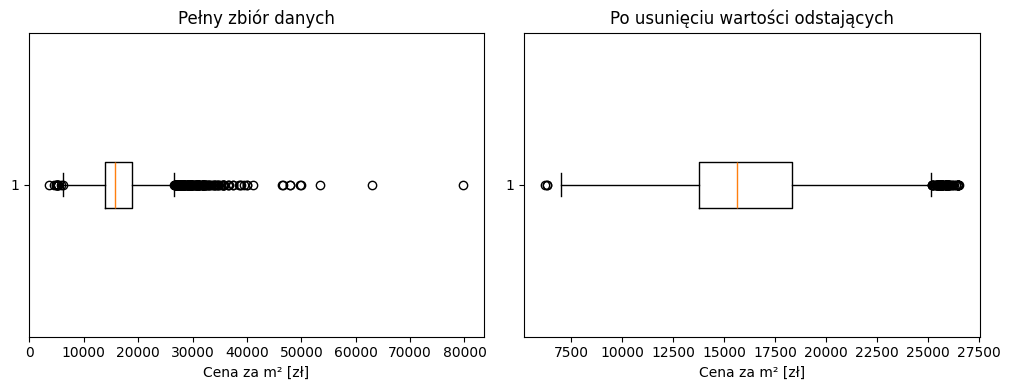

Zapisano: figures/boxplot_price_per_m2_before_after.png


In [17]:
import matplotlib.pyplot as plt
import os

# === Wykres price_per_m2 — przed i po ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# PRZED
axes[0].boxplot(price_per_m2_before, vert=False)
axes[0].set_title("Pełny zbiór danych")
axes[0].set_xlabel("Cena za m² [zł]")

# PO
axes[1].boxplot(price_per_m2_after, vert=False)
axes[1].set_title("Po usunięciu wartości odstających")
axes[1].set_xlabel("Cena za m² [zł]")

plt.tight_layout()

# Zapis
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/boxplot_price_per_m2_before_after.png", dpi=300)
plt.show()

print("Zapisano: figures/boxplot_price_per_m2_before_after.png")

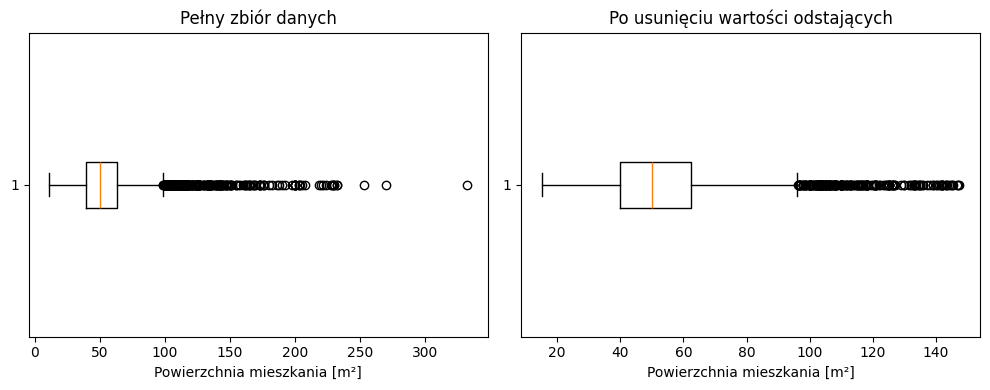

Zapisano: figures/boxplot_area_before_after.png


In [18]:
# === Wykres area — przed i po ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# PRZED
axes[0].boxplot(area_before, vert=False)
axes[0].set_title("Pełny zbiór danych")
axes[0].set_xlabel("Powierzchnia mieszkania [m²]")

# PO
axes[1].boxplot(area_after, vert=False)
axes[1].set_title("Po usunięciu wartości odstających")
axes[1].set_xlabel("Powierzchnia mieszkania [m²]")

plt.tight_layout()

# Zapis
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/boxplot_area_before_after.png", dpi=300)
plt.show()

print("Zapisano: figures/boxplot_area_before_after.png")

In [19]:
# --- Funkcja do podsumowania statystyk ---
def describe_series(series):
    return {
        'min': round(series.min(), 2),
        'max': round(series.max(), 2),
        'mean': round(series.mean(), 2),
        'median': round(series.median(), 2),
        'Q1 (25%)': round(series.quantile(0.25), 2),
        'Q3 (75%)': round(series.quantile(0.75), 2)
    }

# --- Statystyki dla price_per_m2 ---
stats_price_before = describe_series(price_per_m2_before)
stats_price_after = describe_series(price_per_m2_after)

# --- Statystyki dla area ---
stats_area_before = describe_series(area_before)
stats_area_after = describe_series(area_after)

# --- Wydruk tabel ---
import pandas as pd

# Price per m2
df_stats_price = pd.DataFrame({
    'PRZED czyszczeniem': stats_price_before,
    'PO czyszczeniu': stats_price_after
})

# Area
df_stats_area = pd.DataFrame({
    'PRZED czyszczeniem': stats_area_before,
    'PO czyszczeniu': stats_area_after
})

# --- Wyświetlenie ---
print("\nStatystyki — Price per m²:")
display(df_stats_price)

print("\nStatystyki — Area (m²):")
display(df_stats_area)


Statystyki — Price per m²:


,PRZED czyszczeniem,PO czyszczeniu
min,3650.00,6211.00
max,79800.00,26552.00
mean,16855.78,16264.26
median,15818.00,15649.00
Q1 (25%),13816.00,13760.50
Q3 (75%),18925.00,18327.75



Statystyki — Area (m²):


,PRZED czyszczeniem,PO czyszczeniu
min,11.15,15.23
max,332.00,147.30
mean,55.62,53.79
median,50.00,50.00
Q1 (25%),39.63,40.00
Q3 (75%),63.29,62.49


In [20]:
## cechy dodatkowe (extras)
df['balkon'] = df['extras'].str.contains('balkon', na=False, case=False).astype(int)
df['taras'] = df['extras'].str.contains('taras', na=False, case=False).astype(int)
df['piwnica'] = df['extras'].str.contains('piwnica', na=False, case=False).astype(int)

In [21]:
df.to_csv('mieszkania_otodom_cleaned.csv')

In [22]:
df.columns

Index(['advertiser_type', 'area', 'available_from', 'build_year',
       'building_type', 'city', 'description', 'district', 'equipment',
       'extras', 'finish', 'floor', 'floor_number', 'heating', 'latitude',
       'lift', 'location', 'longitude', 'market', 'material', 'media',
       'neighbourhood', 'ownership', 'price', 'price_per_m2', 'region', 'rent',
       'rooms', 'security', 'street', 'title', 'total_floors', 'url',
       'windows', 'coord_type', 'district_original', 'district_clean',
       'district_id', 'balkon', 'taras', 'piwnica'],
      dtype='object')

In [23]:
############# FEATURE ENGINEERING VVVVVVVVVVVVVVV

In [24]:
df = df.drop(columns=['market', 'available_from', 'media', 'equipment'])
#available_from - nie przydatne
#media, equipment - czesto pomijane przy mieszkaniach na sprzedaz, nie maja takiego znaczenia

In [25]:
# ## cechy dodatkowe (extras)
df['balkon'] = df['extras'].str.contains('balkon', na=False, case=False).astype(int)
df['taras'] = df['extras'].str.contains('taras', na=False, case=False).astype(int)
df['piwnica'] = df['extras'].str.contains('piwnica', na=False, case=False).astype(int)

In [26]:
## zabezpieczenia (security)
df['has_monitoring'] = df['security'].str.contains('monitoring|ochrona', 
                                                    na=False, case=False).astype(int)
df['has_teren_zamkniety'] = df['security'].str.contains('teren zamknięty', na=False, case=False).astype(int)